In [1]:
import sys
from pathlib import Path

def add_backend_to_path():
    roots = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for r in roots:
        b = r / "backend"
        if (b / "utils").exists():
            sys.path.insert(0, str(b))
            print("Using backend path:", b)
            return b
    raise RuntimeError("Could not find ./backend. Start Jupyter from repo root.")

BACKEND = add_backend_to_path()


Using backend path: /home/elahe/user/elahe/new-ai-ran-sim/backend


In [2]:
from utils.traffic_trace import (
    validate_raw_packet_trace_csv,
    validate_preaggregated_trace_csv,
    load_raw_packet_csv,
    load_csv_trace,
)
from pathlib import Path


In [4]:
# For raw CSVs (Wireshark exports)
UE_IP = "172.30.1.1"   # used to classify DL/UL
TRACE_BIN = 1.0        # seconds
OVERHEAD_BYTES = 70    # per-packet header/trailer subtraction

# Replay harness parameters
SPEEDUP = 1.0          # 1.0 = realtime
STEP_S = 1.0           # step size of the harness
CAP_Mbps = 20.0        # constant capacity used to 'serve' from buffer

# Files to test
FILES = [
    "backend/assets/traces/embb_04_10.csv",
    "backend/assets/traces/urllc_04_10.csv",
    "backend/assets/traces/mmtc_04_10.csv",
]
print(FILES)
FILES = [f for f in FILES if Path(f).exists()]
print("Files:", FILES)


['backend/assets/traces/embb_04_10.csv', 'backend/assets/traces/urllc_04_10.csv', 'backend/assets/traces/mmtc_04_10.csv']
Files: []


In [6]:
from pathlib import Path

def find_backend(start: Path = Path.cwd()) -> Path:
    p = start
    for _ in range(7):
        if p.name == 'backend' and (p/'assets'/'traces').exists():
            return p
        if (p/'backend'/'assets'/'traces').exists():
            return p/'backend'
        p = p.parent
    raise FileNotFoundError('backend/assets/traces not found upward from ' + str(start))

BACKEND = find_backend()
TRACES = BACKEND / 'assets' / 'traces'
FILES = [str(TRACES / n) for n in ('embb_04_10.csv','urllc_04_10.csv','mmtc_04_10.csv') if (TRACES / n).exists()]
print('BACKEND:', BACKEND)
print('Files:', FILES)


BACKEND: /home/elahe/user/elahe/new-ai-ran-sim/backend
Files: ['/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/mmtc_04_10.csv']


In [8]:
# Raw packet CSVs
for f in FILES:
    res = validate_raw_packet_trace_csv(f)
    print("\nFile:", f)
    print("  exists=", res["exists"], "valid=", res["valid"])
    print("  columns=", res.get("columns"))
    print("  sample_rows_parsed=", res.get("sample_count"), "ue_ip_auto=", res.get("detected_ue_ip"))
    if not res["valid"]:
        print("  error=", res.get("error"))

# If you have pre-aggregated CSVs (t_s,dl_bytes[,ul_bytes]):
# agg_files = ["path/to/embb.csv", "path/to/urllc.csv"]
# for f in agg_files:
#     res = validate_preaggregated_trace_csv(f)
#     print("\nAgg File:", f, "->", res)



File: /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv
  exists= True valid= True
  columns= {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
  sample_rows_parsed= 100 ue_ip_auto= 172.30.1.1

File: /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv
  exists= True valid= True
  columns= {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
  sample_rows_parsed= 100 ue_ip_auto= 172.30.1.1

File: /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/mmtc_04_10.csv
  exists= True valid= True
  columns= {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
  sample_rows_parsed= 100 ue_ip_auto= 172.30.1.1


In [9]:
def load_samples_raw(path, ue_ip=UE_IP, bin_s=TRACE_BIN, overhead=OVERHEAD_BYTES):
    samples = load_raw_packet_csv(path, ue_ip=ue_ip, bin_s=bin_s, overhead_sub_bytes=overhead)
    if samples:
        total_dl = sum(int(s[1] or 0) for s in samples)
        total_ul = sum(int(s[2] or 0) for s in samples)
        duration = samples[-1][0] - samples[0][0] if len(samples) > 1 else 0.0
        print(f"samples={len(samples)}, duration={duration:.3f}s, total_dl={total_dl}B, total_ul={total_ul}B")
        print("head:", samples[:5])
        print("tail:", samples[-5:])
    else:
        print("No samples parsed.")
    return samples

def load_samples_agg(path):
    samples = load_csv_trace(path)
    if samples:
        total_dl = sum(int(s[1] or 0) for s in samples)
        total_ul = sum(int(s[2] or 0) for s in samples)
        duration = samples[-1][0] - samples[0][0] if len(samples) > 1 else 0.0
        print(f"samples={len(samples)}, duration={duration:.3f}s, total_dl={total_dl}B, total_ul={total_ul}B")
        print("head:", samples[:5])
        print("tail:", samples[-5:])
    else:
        print("No samples parsed.")
    return samples

SAMPLES = load_samples_raw(FILES[0])  # choose one file to start


samples=60, duration=294.000s, total_dl=10856852B, total_ul=365094B
head: [(0.0, 15048, 9394), (1.0, 20452, 22544), (2.0, 22206, 16332), (3.0, 1020436, 18598), (4.0, 380990, 6054)]
tail: [(286.0, 410, 1224), (290.0, 1018498, 51108), (291.0, 410808, 9016), (292.0, 182, 1690), (294.0, 880, 21222)]


In [10]:
class SimpleReplayer:
    def __init__(self, samples, speedup=SPEEDUP):
        self.samples = list(samples)
        self.idx = 0
        self.clock = 0.0
        self.speedup = float(speedup)
        self.buf_dl = 0
        self.buf_ul = 0
        self.enq_total = 0
        self.served_total = 0
        self.history = []

    def _tick_trace(self, dt):
        self.clock += dt * self.speedup
        step_enq = 0
        n = len(self.samples)
        while self.idx < n and self.samples[self.idx][0] <= self.clock:
            _, dl, ul = self.samples[self.idx]
            self.buf_dl += int(dl or 0)
            self.buf_ul += int(ul or 0)
            step_enq += int(dl or 0)
            self.idx += 1
        return step_enq

    def step(self, dt=STEP_S, cap_mbps=CAP_Mbps):
        enq_dl = self._tick_trace(dt)
        cap_bytes = int((cap_mbps * 1e6) * dt / 8.0)
        take = min(self.buf_dl, cap_bytes)
        self.buf_dl -= take
        self.enq_total += enq_dl
        self.served_total += take
        rec = {"t": self.clock, "enq_dl": enq_dl, "served": take, "buf_dl": self.buf_dl, "idx": self.idx}
        self.history.append(rec)
        return rec

    def run(self, steps=30, dt=STEP_S, cap_mbps=CAP_Mbps, verbose=True):
        for s in range(steps):
            rec = self.step(dt, cap_mbps)
            if verbose and s < 10:
                print(f"step={s} t={rec['t']:.2f}s enq={rec['enq_dl']}B served={rec['served']}B buf={rec['buf_dl']}B idx={rec['idx']}")
        ok = (self.enq_total == self.served_total + self.buf_dl)
        print(f"\nSummary: enq={self.enq_total}B served={self.served_total}B remaining_buf={self.buf_dl}B -> {'OK' if ok else 'MISMATCH'}")
        return ok


In [11]:
replayer = SimpleReplayer(SAMPLES, speedup=SPEEDUP)
replayer.run(steps=30, dt=STEP_S, cap_mbps=CAP_Mbps, verbose=True)


step=0 t=1.00s enq=35500B served=35500B buf=0B idx=2
step=1 t=2.00s enq=22206B served=22206B buf=0B idx=3
step=2 t=3.00s enq=1020436B served=1020436B buf=0B idx=4
step=3 t=4.00s enq=380990B served=380990B buf=0B idx=5
step=4 t=5.00s enq=187742B served=187742B buf=0B idx=6
step=5 t=6.00s enq=0B served=0B buf=0B idx=6
step=6 t=7.00s enq=0B served=0B buf=0B idx=7
step=7 t=8.00s enq=242B served=242B buf=0B idx=8
step=8 t=9.00s enq=0B served=0B buf=0B idx=8
step=9 t=10.00s enq=0B served=0B buf=0B idx=8

Summary: enq=3043830B served=3043830B remaining_buf=0B -> OK


True

In [12]:
def run_batch(files=FILES, cap_list=(10.0, 50.0)):
    for f in files:
        print("\n===", f, "===")
        samples = load_samples_raw(f)
        for cap in cap_list:
            print(f"\nCapacity {cap} Mbps")
            SimpleReplayer(samples, speedup=SPEEDUP).run(steps=30, dt=STEP_S, cap_mbps=cap, verbose=False)

run_batch()



=== /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv ===
samples=60, duration=294.000s, total_dl=10856852B, total_ul=365094B
head: [(0.0, 15048, 9394), (1.0, 20452, 22544), (2.0, 22206, 16332), (3.0, 1020436, 18598), (4.0, 380990, 6054)]
tail: [(286.0, 410, 1224), (290.0, 1018498, 51108), (291.0, 410808, 9016), (292.0, 182, 1690), (294.0, 880, 21222)]

Capacity 10.0 Mbps

Summary: enq=3043830B served=3043830B remaining_buf=0B -> OK

Capacity 50.0 Mbps

Summary: enq=3043830B served=3043830B remaining_buf=0B -> OK

=== /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv ===
samples=401, duration=426.000s, total_dl=23957902B, total_ul=14647696B
head: [(0.0, 0, 58), (8.0, 14626, 8070), (9.0, 2728, 182), (10.0, 136, 170), (11.0, 106, 68)]
tail: [(421.0, 106, 136), (422.0, 186, 136), (423.0, 38, 34), (424.0, 38, 34), (426.0, 0, 34)]

Capacity 10.0 Mbps

Summary: enq=25410B served=25410B remaining_buf=0B -> OK

Capacity 50.0 Mbps

Summary: en

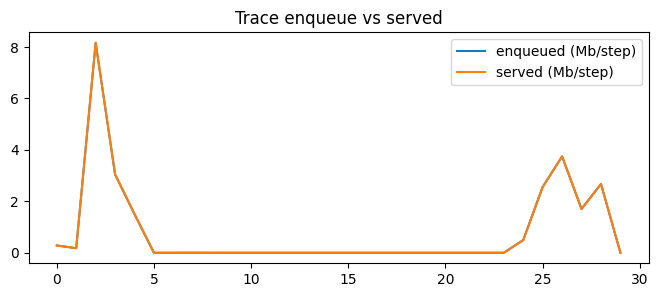

In [13]:
try:
    import matplotlib.pyplot as plt
    h = replayer.history
    enq = [r["enq_dl"] * 8 / 1e6 for r in h]
    srv = [r["served"] * 8 / 1e6 for r in h]
    plt.figure(figsize=(8,3))
    plt.plot(enq, label="enqueued (Mb/step)")
    plt.plot(srv, label="served (Mb/step)")
    plt.legend(); plt.title("Trace enqueue vs served"); plt.show()
except Exception as e:
    print("Plot skipped:", e)
